# Workflow to compare TISSUES and NextProt data

### Import the required packages

In [34]:
## based on the tutorial https://jensenlab.org/training/stringapp/#exercise-3

import os
import sys
from time import sleep
import pandas as pd
import matplotlib
from py2cytoscape import cyrest
from IPython.display import Image
%matplotlib inline

### Setup Cytoscape
TODO: check if apps are installed and if not, install them

In [35]:
cytoscape=cyrest.cyclient()
cytoscape.version()

apiVersion v1
cytoscapeVersion 3.7.2


In [36]:
cytoscape.session.new()

### Protein network retrieval
Retrieve a STRING network for all UniProt identifiers in the table. 

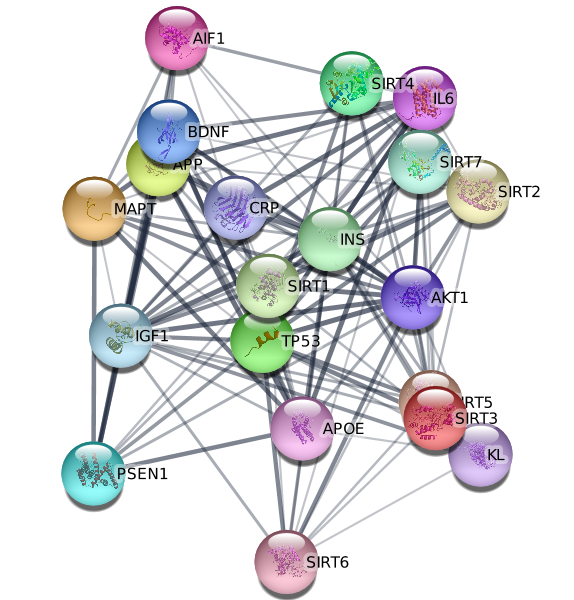

In [37]:
from py2cytoscape.cyrest.base import api
## create the string network with the uniprot ids
api(namespace="string",command="pubmed query",PARAMS={"cutoff": "0.4",
                                                      "limit": "20",
                                                      "pubmed": "aging",
                                                      "species": "homo sapiens",
                                                      "taxonID": "9606"})
sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

### Check for obsolete UniProt IDs

In [38]:
## get list 
uniprotIDs=list(set(cytoscape.table.getTable(columns=['stringdb::canonical name'],table='node')['stringdb::canonical name']))

In [40]:
## convert from STRING UniProt IDs to current IDs / check for obsolete IDs
import urllib.request, urllib.parse, urllib.error,urllib.request,urllib.error,urllib.parse
url = "https://www.uniprot.org/uploadlists/"
params = {
"from":"ACC",
"to":"ACC",
"format":"tab",
"query":"Q9NRC7 P20806 Q9UM73 P97793 Q17192"
}
data = urllib.parse.urlencode(params).encode("utf-8")
request = urllib.request.Request(url, data)
contact = "" # Please set a contact email address here to help us debug in case of problems (see https://www.uniprot.org/help/privacy).
request.add_header("User-Agent", "Python %s" % contact)
response = urllib.request.urlopen(request)
# page = response.read(200000)

In [41]:
# from io import StringIO 
# StringData = StringIO(unicode(page))
uniprot_mapping = pd.read_csv(response, sep ="\t")
uniprot_mapping.head()

,From,To
0,Q9NRC7,Q8N6T7
1,P20806,P20806
2,Q9UM73,Q9UM73
3,P97793,P97793
4,Q17192,Q17192


### Get NextProt data

## Convert NextProt data and merge with TISSUES
Create an OmicsVisualizer table

### process data from sparql query

In [ ]:
#EXPECTS nextprot_output df

# unstack data to get tissues as separate columns
unstacked = nextprot_output.set_index(['entry','PAset'])[['pepcnt']].unstack()

# add gene names back to unstacked data
genes=nextprot_output.set_index('entry')['callret-1']
mapped_genes = unstacked.index.map(genes.to_dict())
unstacked.insert(0,'gene',mapped_genes)

**process nextprot entry to get uniprot id**

In [ ]:
def process_id(entry):
    return entry.strip().split('_')[-1]
unstacked.reset_index(inplace=True)
unstacked.insert(0,'uniprot_id',unstacked['entry'].apply(process_id))

**fill empty values with 0, assign proper column names**

In [44]:
result = unstacked.set_index('uniprot_id').fillna(0)
columns = list(result.columns.droplevel(level=0))
columns[0]='entry'
columns[1]='gene'
result.columns = columns

### Process node table

In [ ]:
# EXPECTS nodes DATAFRAME

# find all tissues column in nodes table
nodes_tissues = [col for col in nodes.columns if 'tissue::' in col]
nodes = nodes.set_index('query term')

# select tissue columns from node table
tissue_data = nodes.loc[:,nodes_tissues]
tissue_data.head()

#### get tissue mapping between nextprot and tissuedb

In [45]:
# dictionary mapping nexprot tissues to TISSUESdb tissues
tissue_mapping = {
    'Adrenal Gland':'tissue::adrenal gland',
    'Blood Cells':'tissue::blood',
    'Blood Plasma':'tissue::blood',
    'Blood':'tissue::blood',
    'Eye':'tissue::eye',
    'Heart':'tissue::heart',
    'Kidney':'tissue::kidney',
    'Liver':'tissue::liver',
    'Lung':'tissue::lung',
    'Brain':'tissue::nervous system',
    'Cerebrospinal Fluid':'tissue::nervous system',
    'Olfactory System':'tissue::nervous system',
    'Pituitary Gland':'tissue::nervous system',
    'Pancreas':'tissue::pancreas',
    'Spleen':'tissue::spleen',
    'Thyroid':'tissue::thyroid gland',
    'Urinary Bladder':'tissue::urine',
    'Ureter':'tissue::urine',
    'Urine':'tissue::urine',
    'Alimentary System':'tissue::intestine',
}

In [46]:
# create dict with list of nextprot tissues belonging to each tissues tissue
tissues_to_np = {}

for key,value in tissue_mapping.items():
    if value in tissues_to_np.keys():
        tissues_to_np[value].append(key)
    else:
        tissues_to_np[value] = [key]

In [48]:
# stack tissues data into the required format
stacked_tissues = pd.DataFrame(tissue_data.stack())
stacked_tissues.columns=['tissues score']
stacked_tissues.head()

### determine peptide evidence for each mapped tissue from nextprot

In [ ]:
next_prot_bools = []

# go over all tissues in nodes data
for ttissue in nodes_tissues:
    # skip tissue if it doesnt map to nextprot
    if not ttissue in tissues_to_np.keys():
        continue
    # get nexprot tissues mapping to this tissue
    np_tissues = tissues_to_np[ttissue]
    # get peptide counts for all these tissues
    counts = result.loc[:,np_tissues]
    # boolean for peptide presence or absence
    summed = counts.sum(axis=1)
    bools = pd.DataFrame(summed!= 0)
    bools.columns = [ttissue]
    # add dataframe to list
    next_prot_bools.append(bools)
    
# concatenate the dataframes with nextprot boolean arrays
nextprot_result = pd.concat(next_prot_bools, axis =1) 

# stack the datataframe to be in the 
# same format as the stacked tissues data
nextprot_stacked = pd.DataFrame(nextprot_result.stack())
nextprot_stacked.reset_index(inplace=True)
nextprot_stacked.columns = ['uniprot_id','tissue','np']
nextprot_stacked.head()

#### merge stacked tissues and stacked nextprot dataframes

In [ ]:
merged_data = stacked_tissues.merge(
    nextprot_stacked,
    how='inner',
    left_index=True,
    right_on=['uniprot_id','tissue'])
merged_data = merged_data[['uniprot_id','tissue','tissues score','np']]

# strip the '::tissue' part from the tissue names
def strip_tissue(value):
    return value.split('::')[-1]
merged_data['tissue'] = merged_data['tissue'].apply(strip_tissue)
merged_data.head()


In [ ]:
merged_data.to_csv(
    './data/stacked_tissues_nextprot.tsv',
    index=False,
    sep='\t')

## Save the session

In [27]:
cytoscape.session.save_as(session_file="tissues_nextprot_merge")